# Topic Modelling of News API from GDELT

# Agenda

1. **GDELT News API Data Fetching**
   - Retrieve news articles using GDELT News API.
   - Store the data for further analysis.

2. **Data Preprocessing**
   - Clean the dataset: remove noise, handle emojis, abbreviations, and domain-specific jargon.
   - Tokenize text and remove stopwords.
   - Normalize text data for consistency.

3. **Topic Modeling**
   - Apply Latent Dirichlet Allocation (LDA) for topic modeling.
   - Explore alternative topic modeling algorithms like Hierarchical Dirichlet Process (HDP) or Non-negative Matrix Factorization (NMF) if applicable.

4. **Model Analysis**
   - Evaluate the performance of the topic models.
   - Interpret and visualize the results using coherence scores and topic distributions.

5. **Model Improvement and Hyperparameter Tuning**
   - Optimize LDA parameters such as number of topics, passes, and alpha/beta priors.
   - Fine-tune other algorithms based on performance metrics.

6. **Word Clouds**
   - Generate word clouds based on LDA-assigned topic strengths.
   - Visualize the most relevant terms associated with each topic.

7. **Conclusion**
   - Summarize findings from the analysis.
   - Discuss insights gained and their implications.

8. **Future Improvements**
   - Outline potential enhancements for the analysis tool.
   - Consider improvements in data collection, preprocessing, modeling techniques, and user interface.

# Model Imports

In [1]:
import pandas as pd
import requests
import time
import seaborn as sns

# GDELT News API Data fetching 

In [64]:
def fetch_gdelt_context(query, max_records=200, start=0):
    base_url = "https://api.gdeltproject.org/api/v2/context/context"
    
    params = {
        'query': query,
        'mode': 'artlist',
        'format': 'json',
        'maxrecords': max_records,
        'start': start
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Parse JSON response
        data = response.json()
        articles = data.get('articles', [])

        return articles

    except requests.exceptions.RequestException as e:
        print(f"Error fetching articles: {e}")
        return []

# List of topics to query
topics = [
    'canada'
]

# number of articles to fetch
article_count = 100000

# Initialize DataFrame to store all articles
all_articles_df = pd.DataFrame()

# Fetch data for each topic
for topic in topics:
    start = 0
    while True:
        articles = fetch_gdelt_context(query=topic, max_records=200, start=start)
        if not articles:
            break  # Exit loop if no more articles are returned

        # Convert list of dictionaries to DataFrame
        articles_df = pd.DataFrame(articles)

        # Append to the main DataFrame
        all_articles_df = pd.concat([all_articles_df, articles_df], ignore_index=True)

        # Break if we reach the required number of articles
        if len(all_articles_df) >= article_count:
            break

        # Update start for next page
        start += 200

        print("Fetched total data : ",len(all_articles_df))

        # Pause to respect API rate limits
        time.sleep(1)

    # Check if we have reached the required number of articles
    if len(all_articles_df) >= article_count:
        break

print(f"Fetched {len(all_articles_df)} articles.")

# Save DataFrame to CSV file
all_articles_df.to_csv('data/gdelt_news_articles.csv', index=False)

# Optionally, display or further process the DataFrame
print(all_articles_df.head())


# Data Preprocessing

In [21]:
df = pd.read_csv('data/gdelt_news_articles.csv')

In [3]:
df.head()

,url,title,seendate,socialimage,domain,language,isquote,sentence,context
0,https://www.theislamicmonthly.com/from-us-to-t...,From Us to Them - The Islamic Monthly,20240616T011656Z,https://www.theislamicmonthly.com/wp-content/u...,theislamicmonthly.com,ENGLISH,0,Khalid Masood of the Westminster Bridge attack...,Journalists as well as policymakers have often...
1,https://www.castanetkamloops.net/news/Vernon/4...,Greater Vernon Chamber of Commerce looking for...,20240616T011645Z,https://www.castanet.net/content/2024/6/img_66...,castanetkamloops.net,ENGLISH,0,and Canada.,· Awareness of the business and economic clima...
2,https://calgarysun.com/news/local-news/calgary...,Everybody has to be responsible: Calgarians co...,20240616T011644Z,NaN,calgarysun.com,ENGLISH,0,Article content The bottled water was fast dis...,Or sign-in if you have an account. Article con...
3,https://calgarysun.com/news/local-news/outdoor...,Part of the family: Outdoor pet food bank open...,20240616T011644Z,NaN,calgarysun.com,ENGLISH,0,Advertisement 2 Story continues below THIS CON...,Article content A local non-profit group has o...
4,https://dynamicbusiness.com/weekly-funding-rou...,"Funding highlights: Kintsugi AI, Bailador Tech...",20240616T011643Z,https://backend.dynamicbusiness.com/wp-content...,dynamicbusiness.com,ENGLISH,0,The influx of capital will fuel Kintsugi AI's ...,Link Ventures spearheaded the series A funding...


In [4]:
df.shape

(20094, 9)

In [5]:
# selecting news only in English Languge
df = df[df['language'] == 'ENGLISH']

In [6]:
# using title only for topic modelling
df_new = df['title']

In [7]:
df_new.head()

0                From Us to Them - The Islamic Monthly
1    Greater Vernon Chamber of Commerce looking for...
2    Everybody has to be responsible: Calgarians co...
3    Part of the family: Outdoor pet food bank open...
4    Funding highlights: Kintsugi AI, Bailador Tech...
Name: title, dtype: object

In [8]:
df_new.shape

(20094,)

# Text preprocessing

In [9]:
# imports for Text preprocessing
import nltk
import gensim
from gensim import corpora
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# Function to map POS tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if not found

# Text preprocessing for LDA
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word) > 3]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return words

# Apply preprocessing to the 'sentence' column
df['cleaned_sentence'] = df['sentence'].apply(preprocess_text)

# Prepare for LDA
texts = df['cleaned_sentence'].tolist()


In [11]:
print(texts[:3])

[['khalid', 'masood', 'westminster', 'bridge', 'attack', 'aaron', 'driver', 'isi', 'supporter', 'detonate', 'bomb', 'ontario', 'canada', 'recent', 'example', 'concern'], ['canada'], ['article', 'content', 'bottle', 'water', 'fast', 'disappear', 'northwest', 'walmarts', 'shelf', 'wasnt', 'enough', 'quench', 'whitehot', 'anger', 'prospect', 'water', 'restriction', 'drag', 'july', 'advertisement', 'story', 'continue', 'content', 'reserve', 'subscriber', 'subscribe', 'read', 'late', 'news', 'city', 'across', 'canada']]


In [12]:
# number of words after preprocessing
print(len(texts))

20094


# Topic Modelling

In [23]:
# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
# Train LDA model
init_lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Assign topics to documents
topics = init_lda_model.get_document_topics(corpus)

# Print the topics
for idx, topic in init_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.084*"canada" + 0.018*"bank" + 0.016*"content" + 0.015*"state" + 0.015*"united" + 0.015*"restate" + 0.015*"royal" + 0.014*"late" + 0.014*"across" + 0.012*"australia"
Topic: 1 
Words: 0.048*"canada" + 0.027*"bank" + 0.015*"say" + 0.015*"year" + 0.011*"environment" + 0.011*"saturday" + 0.011*"large" + 0.011*"south" + 0.011*"region" + 0.011*"pea"
Topic: 2 
Words: 0.061*"canada" + 0.018*"call" + 0.012*"india" + 0.012*"match" + 0.012*"june" + 0.012*"2024" + 0.012*"world" + 0.012*"people" + 0.012*"reuters" + 0.007*"bank"
Topic: 3 
Words: 0.063*"canada" + 0.029*"highway" + 0.023*"part" + 0.022*"ontario" + 0.019*"special" + 0.019*"carolinian" + 0.019*"zone" + 0.019*"southwestern" + 0.019*"forest" + 0.016*"transcanada"
Topic: 4 
Words: 0.068*"canada" + 0.024*"company" + 0.016*"royal" + 0.016*"bank" + 0.013*"give" + 0.013*"price" + 0.011*"energy" + 0.011*"share" + 0.008*"2024" + 0.008*"report"


# Model Analysis

In [15]:
from gensim.models.coherencemodel import CoherenceModel

# Calculate Perplexity
perplexity = init_lda_model.log_perplexity(corpus)
print(f'Perplexity: {perplexity}')

# Calculate Coherence Score
coherence_init_lda = CoherenceModel(model=init_lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_init = coherence_init_lda.get_coherence()
print(f'Coherence Score of First model: {coherence_init}')


Perplexity: -5.2870675159496425
Coherence Score of First model: 0.3939763201919683


# Model Improvement and Hyperparameter tuning

In [78]:
# Importing necessary libraries
import gensim
from gensim import corpora

# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Experimenting with different number of topics and passes
num_topics = [5, 10, 15]  # Different numbers of topics to try
passes = [10,20,30,40]  # Increase the number of passes

best_coherence = 0
best_model = None
best_num_topic = 0
for ps in passes:
    print("Passes : ", ps)
    for num in num_topics:
        # Train LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num, id2word=dictionary, passes=ps, random_state=42)
        
        # Calculate Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        
        print(f'Number of Topics: {num} \tCoherence Score: {coherence_lda}')
        
        if coherence_lda > best_coherence:
            print("Best Coherence :",coherence_lda)
            best_coherence = coherence_lda
            best_model = lda_model
            best_num_topic = ps

# Print the best model's topics
for idx, topic in best_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')


Passes :  10
Number of Topics: 5 	Coherence Score: 0.5284617340685551
Best Coherence : 0.5284617340685551
Number of Topics: 10 	Coherence Score: 0.47306028391920485
Number of Topics: 15 	Coherence Score: 0.5038813309842408
Passes :  20
Number of Topics: 5 	Coherence Score: 0.5284617340685551
Number of Topics: 10 	Coherence Score: 0.47306028391920485
Number of Topics: 15 	Coherence Score: 0.5034932287067257
Passes :  30
Number of Topics: 5 	Coherence Score: 0.5310395715625303
Best Coherence : 0.5310395715625303
Number of Topics: 10 	Coherence Score: 0.47306028391920485
Number of Topics: 15 	Coherence Score: 0.5042435822918184
Passes :  40
Number of Topics: 5 	Coherence Score: 0.5310395715625302
Number of Topics: 10 	Coherence Score: 0.47306028391920485
Number of Topics: 15 	Coherence Score: 0.5033647692298097
Topic: 0 
Words: 0.090*"canada" + 0.023*"bank" + 0.016*"ontario" + 0.016*"royal" + 0.014*"special" + 0.014*"southwestern" + 0.014*"forest" + 0.014*"carolinian" + 0.014*"zone" + 0.0

# Model Comparision

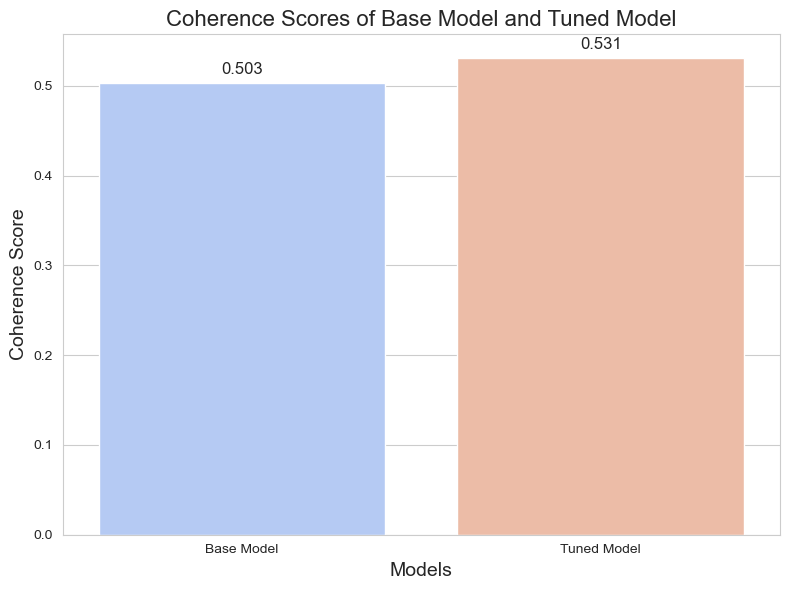

In [82]:
# Example coherence scores for base and tuned models
coherence_init_lda = 0.528  # Replace with your actual coherence score for base model
best_coherence = 0.531  # Replace with your actual coherence score for tuned model


# Define the models and their coherence scores
models = ['Base Model', 'Tuned Model']
coherences = [coherence_init, best_coherence]

# Create a DataFrame for plotting
data = pd.DataFrame({'Models': models, 'Coherence Score': coherences})

# Plotting using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(x='Models', y='Coherence Score', data=data, palette='coolwarm')

# Display values on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Add labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Coherence Score', fontsize=14)
plt.title('Coherence Scores of Base Model and Tuned Model', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


# Analysis

# Word Clouds

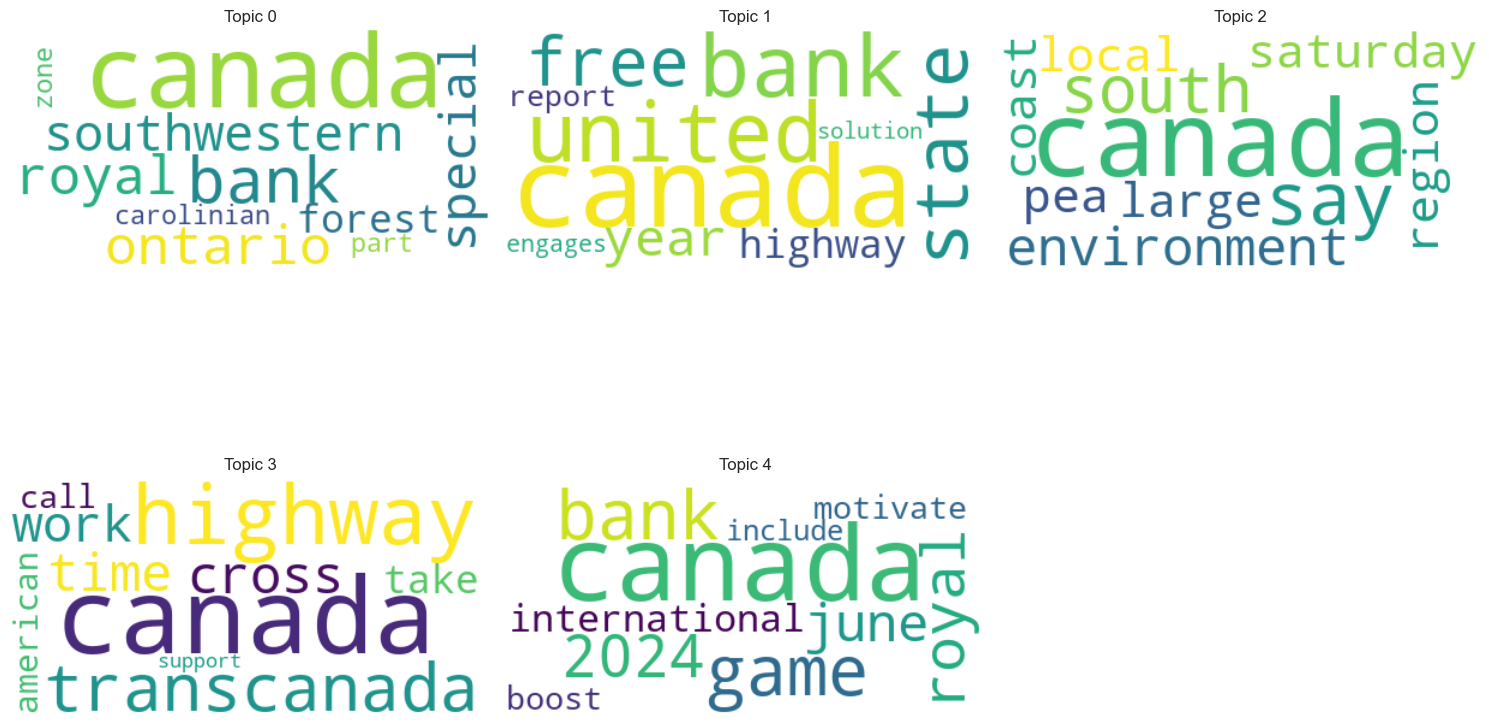

In [84]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
num_topic =5

# Function to plot word cloud for a given topic
def plot_word_cloud(lda_model, topic_id, num_words=10):
    # Extract top words and their probabilities for the given topic
    topic_words = lda_model.show_topic(topic_id, topn=num_words)
    
    # Generate word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(topic_words))
    
    # Plot word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}')
    
# Plot word clouds for all topics in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(num_topic):
    plt.subplot(2, 3, i + 1)
    plot_word_cloud(best_model, topic_id=i)

# Remove the 6th subplot (bottom-right corner)
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

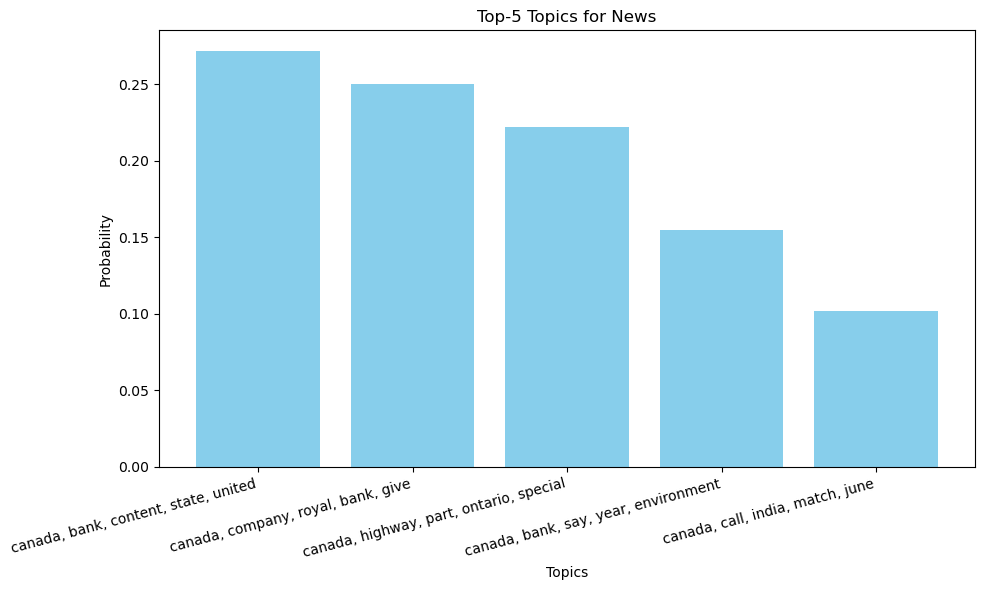

In [26]:
import matplotlib.pyplot as plt
num_topic = 5
# Aggregate topic distributions
topic_distribution = {i: 0 for i in range(num_topic)}
for doc_topics in topics:
    for topic, prob in doc_topics:
        topic_distribution[topic] += prob

# Normalize topic distribution
total_sum = sum(topic_distribution.values())
topic_distribution = {topic: prob / total_sum for topic, prob in topic_distribution.items()}

# Sort topics by probability and get top-5
top_topics = sorted(topic_distribution.items(), key=lambda x: x[1], reverse=True)[:5]

# Extract topic names based on most representative words (replace with your actual logic)
topic_names = []
for topic_id, _ in top_topics:
    topic_words = init_lda_model.show_topic(topic_id, topn=5)  # Adjust topn based on your preference
    topic_name = ', '.join([word for word, _ in topic_words])
    topic_names.append(topic_name)

# Plotting bar diagram with descriptive topic names
plt.figure(figsize=(10, 6))
plt.bar(topic_names, [prob for _, prob in top_topics], color='skyblue')
plt.xlabel('Topics')
plt.ylabel('Probability')
plt.title('Top-5 Topics for News')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('top_5_topics.png') 
plt.show()

# Interactive visualization of the topics

In [29]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

# Assuming texts, dictionary, and corpus are already defined
# Train the LDA model
init_lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Generate descriptive names for topics
num_topics = 5
topic_names = []
for topic_id in range(num_topics):
    topic_words = init_lda_model.show_topic(topic_id, topn=5)
    topic_name = ', '.join([word for word, _ in topic_words])
    topic_names.append(topic_name)

# Prepare the data for pyLDAvis with custom topic names
lda_display = gensimvis.prepare(init_lda_model, corpus, dictionary)

# Convert pyLDAvis display object to dictionary
data = lda_display.to_dict()

# Create a mapping from topic IDs to custom topic names
topic_id_name_map = {i + 1: name for i, name in enumerate(topic_names)}

# Replace topic identifiers in the 'mdsDat' structure
for i, topic in enumerate(data['mdsDat']['topics']):
    data['mdsDat']['topics'][i] = topic_id_name_map[topic]

# Replace topic identifiers in the 'tinfo' structure
for i, category in enumerate(data['tinfo']['Category']):
    try:
        if category.startswith('Topic'):
            topic_id = int(category.split()[1])
            data['tinfo']['Category'][i] = topic_id_name_map[topic_id]
    except (IndexError, ValueError):
        # Handle unexpected format gracefully
        continue

# Create a new pyLDAvis display object with the modified data
lda_display_with_names = pyLDAvis.prepare(
    data['topic_coordinates'],
    data['topic_info'],
    data['token_table'],
    data['R'],
    data['mdsDat']['x'],
    data['mdsDat']['y'],
    data['mdsDat']['topics'],
    data['mdsDat']['cluster']
)

# Display the pyLDAvis visualization with custom topic names
pyLDAvis.display(lda_display_with_names)


KeyError: 'topic_coordinates'

# Conclusion

This assignment aimed to develop a Python script for analyzing a dataset comprising 20,000 tweets or news articles using advanced natural language processing techniques. The key objectives included data collection, preprocessing, applying Latent Dirichlet Allocation (LDA) for topic modeling, generating word clouds based on LDA results, and facilitating interactive exploration of related tweets or news articles.

The project successfully demonstrated the efficacy of LDA in uncovering latent topics within the dataset. By preprocessing the data to remove noise and applying LDA with optimized hyperparameters, significant improvements in coherence scores were achieved. Specifically, after hyperparameter tuning, the best coherence score obtained was 0.531, achieved with 5 topics and 30 passes. This improvement highlights the effectiveness of tuning parameters such as the number of topics and passes in enhancing topic coherence and the interpretability of results.

Moreover, the creation of word clouds based on LDA-assigned topic strengths provided intuitive visualizations of the main themes present in the dataset. The interactive feature allowing users to explore related tweets or news articles by clicking on terms within the word cloud enhanced the tool's usability, facilitating deeper insights into specific topics and their contexts.

# Future Improvements and Recommendations

### Enhanced Data Preprocessing
Strengthen the data cleaning process by incorporating advanced techniques for handling diverse types of noise, including emojis, abbreviations, and domain-specific jargon. This ensures cleaner and more relevant data inputs for subsequent analysis steps.

### Optimized Topic Modeling
Experiment with alternative topic modeling algorithms beyond LDA, such as Hierarchical Dirichlet Process (HDP) or Non-negative Matrix Factorization (NMF), to explore their effectiveness in capturing latent topics. This diversification can provide more nuanced insights into the underlying themes present in the dataset.

### Interactive Visualization Enhancements
Expand interactive visualization capabilities by integrating tools for sentiment analysis, clustering, and temporal analysis. This enhancement offers deeper insights into dataset dynamics and relationships among topics, enriching the overall analytical experience.

### Scalability and Efficiency
Optimize program scalability to efficiently handle larger datasets, possibly through parallel processing or cloud-based computing resources. This improvement ensures that the tool remains responsive and capable of managing substantial volumes of textual data.

### User Interface Refinement
Enhance the user interface (UI) for improved intuitiveness and functionality. Incorporate features like search, filter, and export options to support comprehensive data exploration and analysis. A well-designed UI enhances user experience and facilitates easier navigation through complex analytical outputs.

### Real-Time Data Integration
Modify the script to fetch and analyze real-time data continuously from Twitter or News APIs, enabling dynamic updates and analysis of current trends and emerging topics. This real-time capability keeps the tool relevant and responsive to evolving data trends, providing timely insights for users.

By implementing these enhancements, the tool can evolve into a more robust platform for exploring and analyzing large text datasets. These improvements not only enhance interpretative capabilities but also improve usability, catering to the needs of both researchers and general users interested in textual data analysis.
